In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

In [2]:
BASE_PATH = './data/'
PATH_malignancy_all = BASE_PATH + 'thyroid_feature_all.csv'
PATH_malignancy_test = BASE_PATH + 'thyroid_feature_198.csv'

def get_feature_and_label(df_data, var_label):
    X = df_data.drop([var_label], axis = 1)
    y = df_data[var_label]
    
    return X, y

def get_roc_curve(y_pred_prob, y):
    fpr, tpr, _ = roc_curve(y, y_pred_prob[:,1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic xgb')
    plt.legend(loc="lower right")
    plt.show()

In [47]:
# Load malignancy feature data
df_malignancy_all = pd.read_csv(PATH_malignancy_all)
df_malignancy_test = pd.read_csv(PATH_malignancy_test)
id_train = set(df_malignancy_all['id']) - set(df_malignancy_test['id'])
id_test = list(df_malignancy_test['id'])
df_malignancy_train = pd.DataFrame({'id': list(id_train)})
df_malignancy_train = df_malignancy_train.merge(df_malignancy_all, how='left')

# Train-validation split
df_malignancy_train, df_malignancy_val = train_test_split(df_malignancy_train, test_size=0.2)

df_malignancy_train = df_malignancy_train.drop(['id'], axis=1)
df_malignancy_val = df_malignancy_val.drop(['id'], axis=1)
df_malignancy_test = df_malignancy_test.drop(['id'], axis=1)

var_label = 'label'
X_train, y_train = get_feature_and_label(df_malignancy_train, var_label)
X_val, y_val = get_feature_and_label(df_malignancy_val, var_label)
X_test, y_test = get_feature_and_label(df_malignancy_test, var_label)

print('label imbalance: ', sum(y_train==1)/sum(y_train==0))

label imbalance:  0.544574982722875


In [63]:
classifier_lr = LogisticRegression(max_iter=500)
X_train_impute = X_train.fillna(0)
X_val_impute = X_val.fillna(0)
X_test_impute = X_test.fillna(0)

classifier_lr.fit(X_train_impute, y_train)

y_train_pred_prob = classifier_lr.predict_proba(X_train_impute)
y_val_pred_prob = classifier_lr.predict_proba(X_val_impute)
y_test_pred_prob = classifier_lr.predict_proba(X_test_impute)

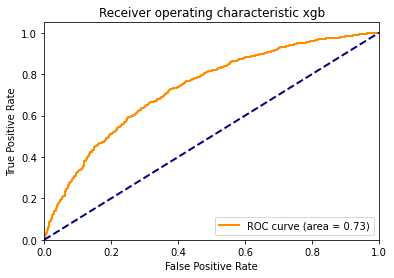

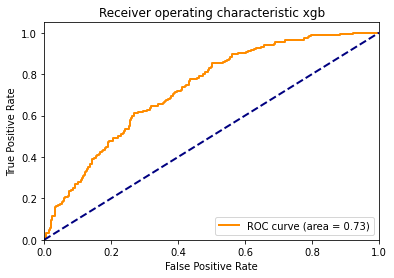

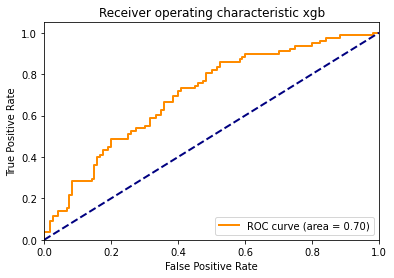

In [64]:
get_roc_curve(y_train_pred_prob, y_train)
get_roc_curve(y_val_pred_prob, y_val)
get_roc_curve(y_test_pred_prob, y_test)

In [56]:
eval_set  = [(X_train,y_train), (X_val,y_val)]
classifier_xgb = XGBClassifier(
    n_estimators=5000,
    scale_pos_weight = 1.8,
    eta = 0.1,  
    max_depth = 2,
).fit(
    X_train, 
    y_train, 
    eval_set=eval_set,
    eval_metric="auc", 
    early_stopping_rounds=10, 
    verbose=1
)

[0]	validation_0-auc:0.68190	validation_1-auc:0.67352
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.71534	validation_1-auc:0.71310
[2]	validation_0-auc:0.71550	validation_1-auc:0.71323
[3]	validation_0-auc:0.72171	validation_1-auc:0.71618
[4]	validation_0-auc:0.72439	validation_1-auc:0.71843
[5]	validation_0-auc:0.73066	validation_1-auc:0.72609
[6]	validation_0-auc:0.73391	validation_1-auc:0.73132
[7]	validation_0-auc:0.73398	validation_1-auc:0.73590
[8]	validation_0-auc:0.74159	validation_1-auc:0.73686
[9]	validation_0-auc:0.74129	validation_1-auc:0.73582
[10]	validation_0-auc:0.74152	validation_1-auc:0.73306
[11]	validation_0-auc:0.74397	validation_1-auc:0.73585
[12]	validation_0-auc:0.74566	validation_1-auc:0.73645
[13]	validation_0-auc:0.74695	validation_1-auc:0.73735
[14]	validation_0-auc:0.74786	validation_1-auc:0.73540
[15]	validation_0-auc:0.7483

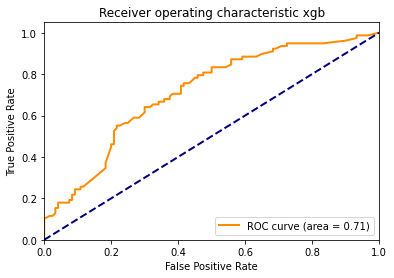

In [57]:
y_test_pred_prob = xgb.predict_proba(X_test, ntree_limit=classifier_xgb.best_ntree_limit)
get_roc_curve(y_test_pred_prob, y_test)